<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrames

我们通过使用`dask.delayed`在 CSV 文件目录上构建并行数据模型计算，完成了第一章。在本节中，我们使用`dask.datataframe`自动构建类似的计算，用于表格计算的常见情况。  
虽然 Dask 的数据库看起来和感觉上都很像pandas的数据库，但它们运行在同一个基础设施上，而这个基础设施正是`dask.delayed`的动力来源。

在这个笔记本中，我们像以前一样使用相同的航线数据，但是现在我们让`dask.dataframe’`为我们构造计算，而不是写 for-loop。函数可以接受`data/nycflights/*`这样的全局字符串,然后在我们所有的数据上建立并行计算。

## 何时使用 `dask.dataframe`

Pandas非常适合存储在内存中的表格数据集。当要分析的数据集大于机器的内存时，Dask 就变得有用了。我们使用的演示数据集大约只有200mb，因此你可以在合理的时间内下载它，但是`dask.dataframe`将扩展到比内存大得多的数据集。

<img src="images/pandas_logo.png" align="right" width="28%">

`dask.dataframe`模块实现了一个分块的并行`DataFrame`对象，模拟了 Pandas 的一个大子集`DataFrame`。一个Dask `DataFrame`是由许多内存中的pandas `DataFrame`组成的，`DataFrame`沿索引分开。在 Dask `DataFrame`上的一个操作触发了许多对子pandas`DataFrame`的pandas操作，这种操作注意到了潜在的并行性和内存限制。

**相关文档**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

**主要知识**

1.  Dask DataFrame对pandas用户来说应该很熟悉
2.  数据流的划分对于有效执行非常重要

## 创建数据

In [1]:
%run prep.py -d flights

## 设置

In [2]:
from dask.distributed import Client

client = Client(n_workers=12)

我们创造了人造数据。

In [3]:
from prep import accounts_csvs
accounts_csvs()

import os
import dask
filename = os.path.join('data', 'accounts.*.csv')
filename

'data/accounts.*.csv'

文件名包含一个通配符`*`，因此路径中与该模式匹配的所有文件将被读入相同的 Dask DataFrame。

In [4]:
import dask.dataframe as dd
df = dd.read_csv(filename)
df.head()

,id,names,amount
0,324,Michael,1235
1,324,Michael,1268
2,152,Alice,5359
3,387,George,4214
4,386,Xavier,1024


In [5]:
# 加载并计算行数
len(df)

3000000

这里发生了什么？
- Dask 调查了输入路径，发现有三个匹配的文件
- 为每个块智能地创建一组作业——在这个例子中，每个原始 CSV 文件创建一个
- 每个文件都被加载到一个pandas DataFrame中，并计算`len()`
- 合并分类的和，最后得出最终总额。

### 真实数据

让我们以几年来在美国的航班为例来尝试一下。这些数据是专门针对纽约市地区三个机场的航班。

In [6]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

请注意，DataFrame对象的描述不包含任何数据 —— Dask 刚刚读取了第一个文件的开头，并推断出了列名和 dtype。

In [7]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


我们可以查看数据的开始和结束

In [8]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [9]:
df.tail()  # 这里会报错

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

### 刚刚发生了什么？

不像 `pandas.read_csv` 在推断数据类型之前读取整个文件, `dask.dataframe.read_csv` 只读取文件开头的样本 (或者是第一个文件，如果使用glob的话). 然后在读取所有分区时强制执行这些推断的数据类型。

在这本案例中，示例中推断的数据类型是不正确的。前`n`行对于`CRSElapsedTime`没有任何值(pandas 将其推断为`float`) ，后来才证明是字符串(`object` dtype)。注意，Dask 提供了关于不匹配的信息性错误消息。当这种情况发生时，你有几个选择：
- 直接使用`dtype`关键字指定 dtype。这是推荐的解决方案，因为它是最不容易出错的(最好是显式的而不是隐式的) ，也是性能最好的。
- 增加`sample`关键字的大小(以字节为单位)
- 使用`assume _ missing`使`dask`假设推断为‘ int’(不允许缺失值)的列实际上是浮点数(允许缺失值)。在我们的特殊情况下，这并不适用。  
在我们的示例中，我们将使用第一个选项并直接指定违规列的`dtypes`。

In [11]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,   #显式指定每列的dtype
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [12]:
df.tail()  # 现在ok了

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


## 使用 `dask.dataframe` 计算

我们计算`DepDelay`列的最大值。 仅使用pandas，我们将遍历每个文件以找到各个最大值，然后在所有各个最大值上找到最终最大值

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

我们可以用`dask.delayed`来包装`pd.read_csv`使其并行运行。 无论如何，我们仍然必须考虑循环，中间结果（每个文件一个）和最终减少量（中间最大值的`max`）。这只是围绕真实任务的噪音，pandas用以下代码来解决

```python
df = pd.read_csv(filename, dtype=dtype)
df.DepDelay.max()
```

`dask.dataframe` 让我们编写类似于pandas的代码，该代码可以并行处理大于内存数据集的操作。

In [13]:
%time df.DepDelay.max().compute()

CPU times: user 509 ms, sys: 88 ms, total: 597 ms
Wall time: 5.52 s


1435.0

这将为我们编写延迟的计算，然后运行它。 

注意事项：

1.  与 `dask.delayed` 一样, 当我们完成后，需要调用 `.compute()` .  到目前为止，一切都是lazy的.
2.  dask会尽快删除中间结果 (比如每个文件对应的完整pandas dataframe).
    -  这使我们可以处理大于内存的数据集
    -  这意味着重复的计算每次都必须加载所有数据（再次运行上面的代码，它比您期望中的速度的快了还是慢了？）
    
与`Delayed`对象一样，您可以使用`.visualize`方法查看基础任务图：

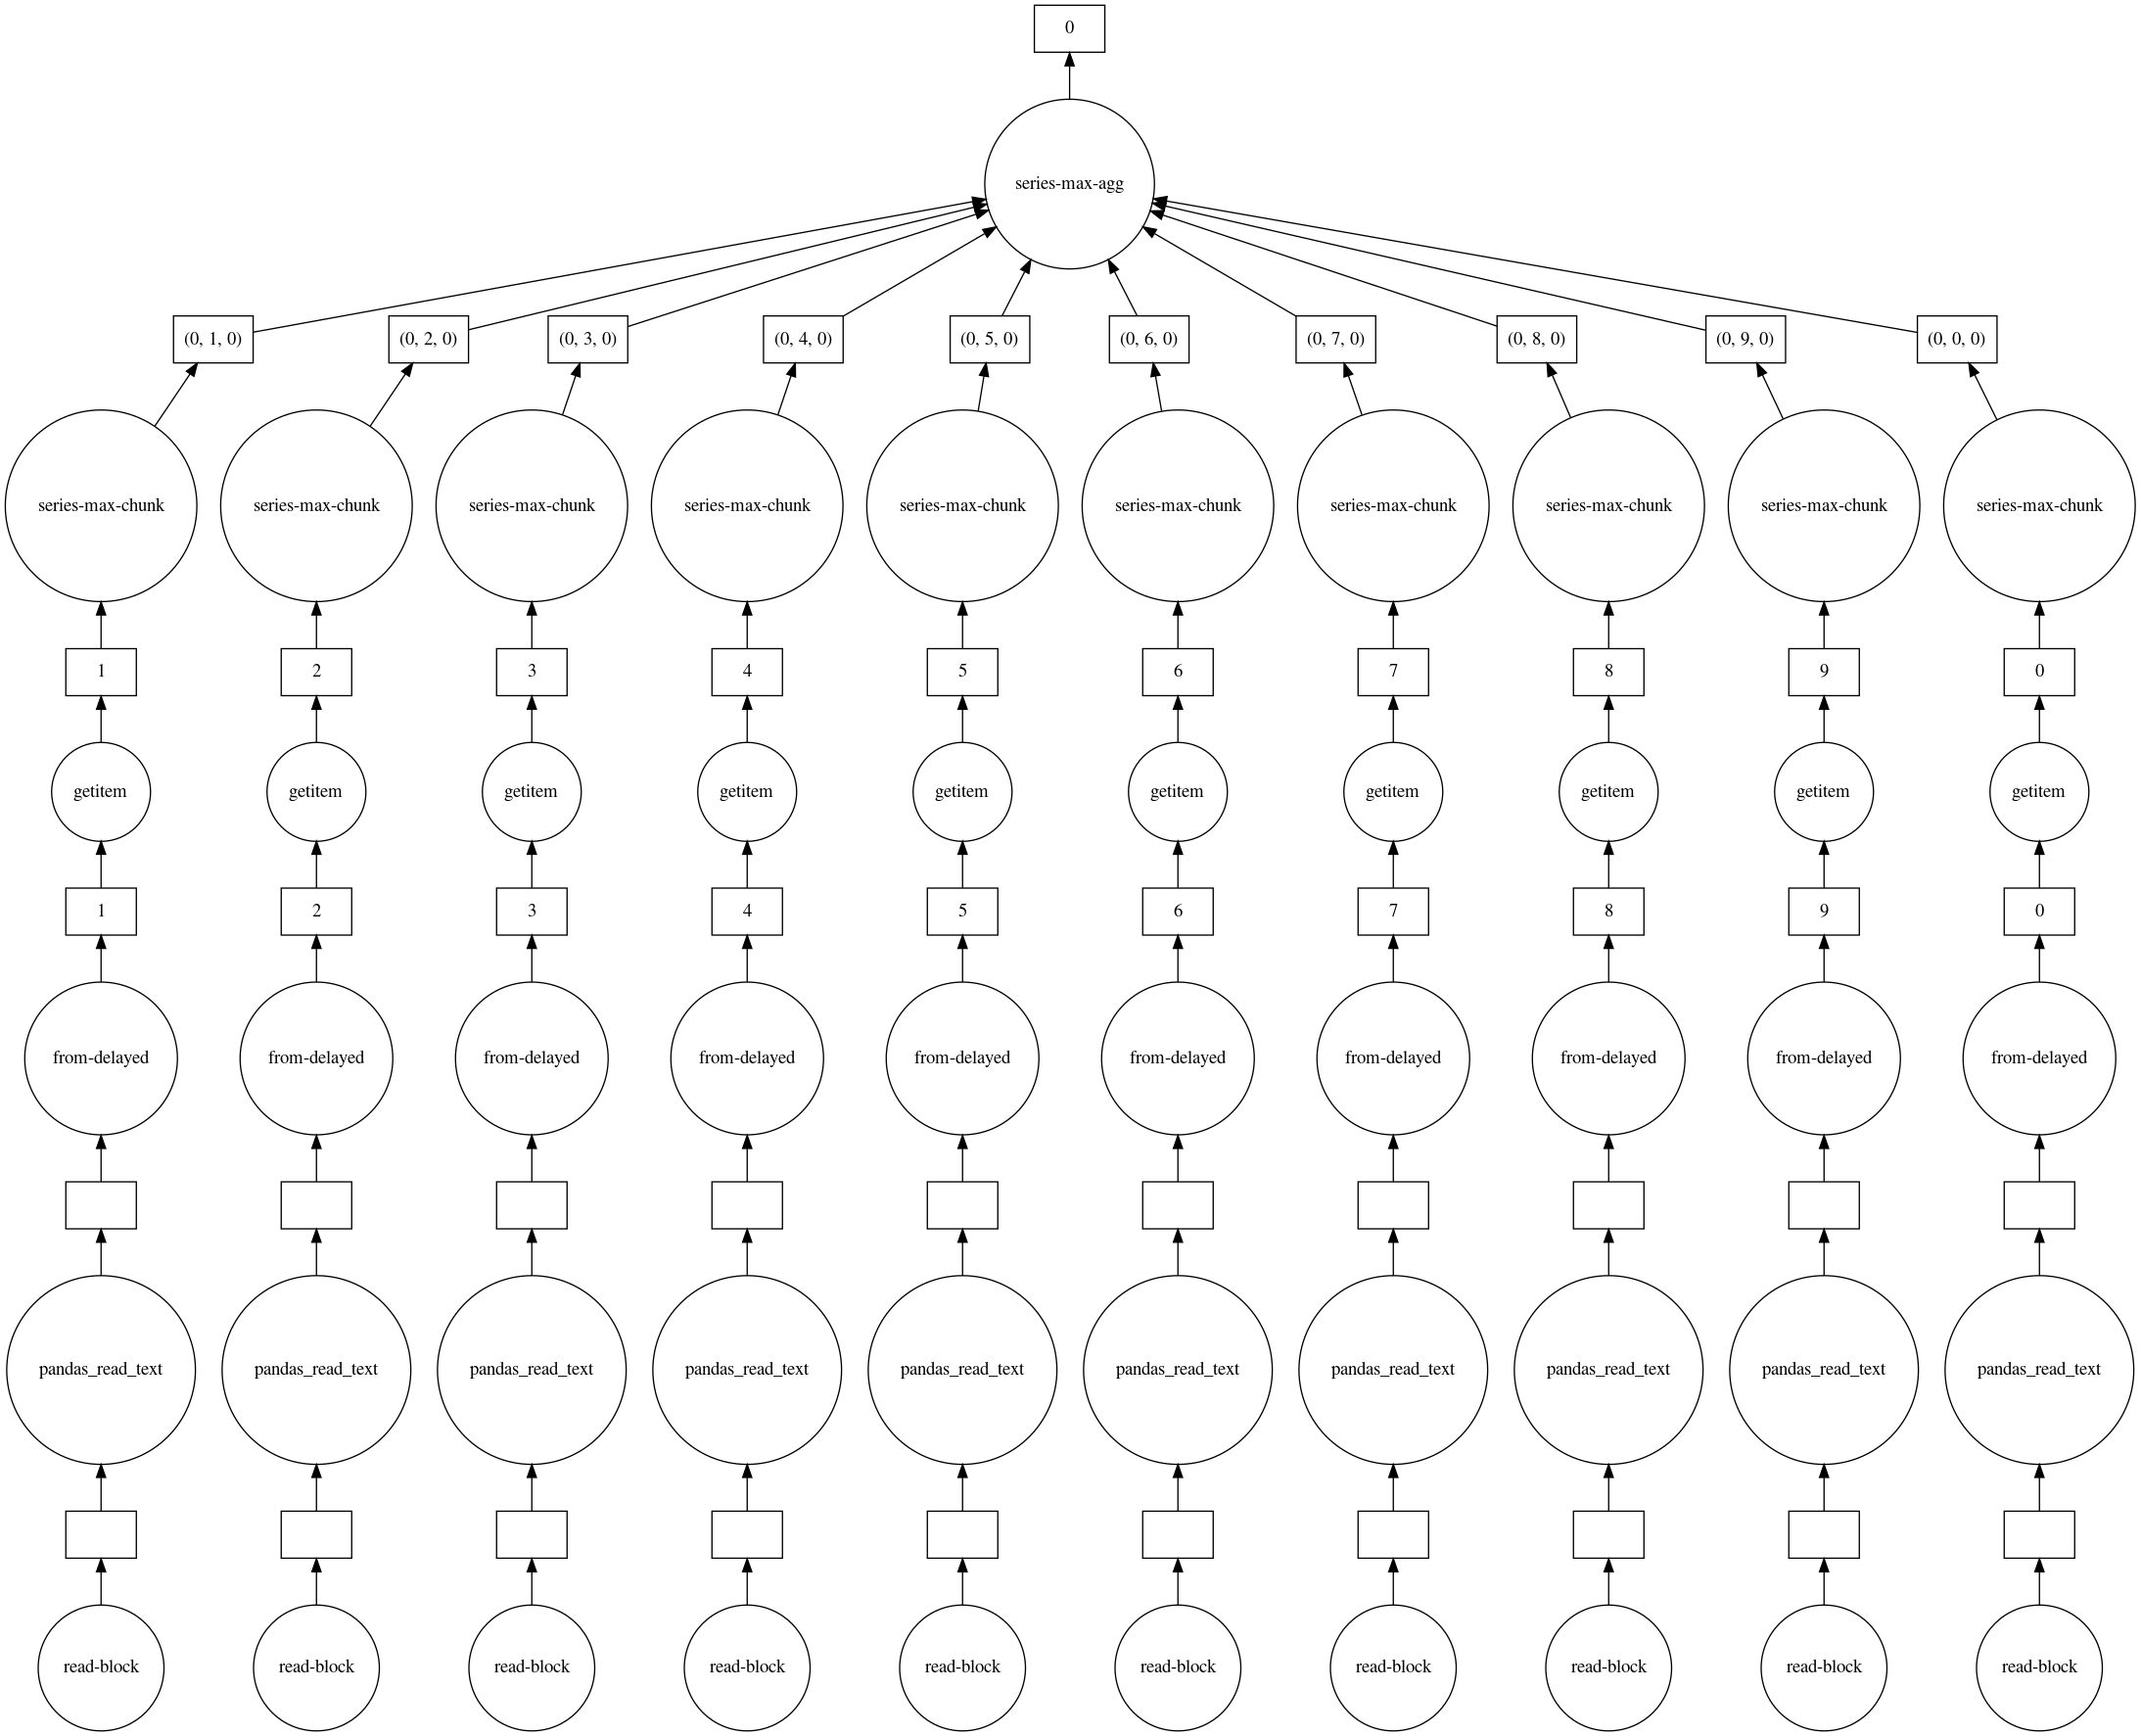

In [17]:
# 注意并行
df.DepDelay.max().visualize()

## 练习

本节中我们进行了一些 `dask.dataframe` 计算. 如果您对pandas很适应，那么这些应该很熟悉. 您将需要思考何时调用 `compute`.

### 1.) 数据集有多少行?

如果您不熟悉pandas，您将如何检查元组列表中有多少条记录？

In [ ]:
# Your code here

In [15]:
len(df)

2611892

### 2.) 总共有多少非取消（non-canceled）航班？

用pandas的话，您需要使用 [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing).

In [ ]:
# Your code here

In [ ]:
len(df[~df.Cancelled])

### 3.) 每个机场总共有多少非取消（non-canceled）航班？

*提示*: 使用 [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [ ]:
# Your code here

In [18]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### 4.) What was the average departure delay from each airport?

Note, this is the same computation you did in the previous notebook (is this approach faster or slower?)

In [ ]:
# Your code here

In [ ]:
df.groupby("Origin").DepDelay.mean().compute()

### 5.) What day of the week has the worst average departure delay?

In [ ]:
# Your code here

In [ ]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since dask operations are lazy, those values aren't the final results yet. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [ ]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [ ]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

But lets try by passing both to a single `compute` call.

In [ ]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (we might want to use `filename='graph.pdf'` to zoom in on the graph better):

In [ ]:
dask.visualize(mean_delay, std_delay)

## How does this compare to Pandas?

Pandas is more mature and fully featured than `dask.dataframe`.  If your data fits in memory then you should use Pandas.  The `dask.dataframe` module gives you a limited `pandas` experience when you operate on datasets that don't fit comfortably in memory.

During this tutorial we provide a small dataset consisting of a few CSV files.  This dataset is 45MB on disk that expands to about 400MB in memory. This dataset is small enough that you would normally use Pandas.

We've chosen this size so that exercises finish quickly.  Dask.dataframe only really becomes meaningful for problems significantly larger than this, when Pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler allows the same dataframe expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_csv`, where the data is held on storage accessible to every worker node (e.g., amazon's S3), and because most operations begin by selecting only some columns, transforming and filtering the data, only relatively small amounts of data need to be communicated between the machines.

Dask.dataframe operations use `pandas` operations internally.  Generally they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task.  This is usually negligible.
2.  When Pandas releases the GIL (coming to `groupby` in the next version) `dask.dataframe` can call several pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to get the same speedup.

## Dask DataFrame Data Model

For the most part, a Dask DataFrame feels like a pandas DataFrame.
So far, the biggest difference we've seen is that Dask operations are lazy; they build up a task graph instead of executing immediately (more details coming in [Schedulers](05_distributed.ipynb)).
This lets Dask do operations in parallel and out of core.

In [Dask Arrays](03_array.ipynb), we saw that a `dask.array` was composed of many NumPy arrays, chunked along one or more dimensions.
It's similar for `dask.dataframe`: a Dask DataFrame is composed of many pandas DataFrames. For `dask.dataframe` the chunking happens only along the index.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

We call each chunk a *partition*, and the upper / lower bounds are *divisions*.
Dask *can* store information about the divisions. For now, partitions come up when you write custom functions to apply to Dask DataFrames

## Converting `CRSDepTime` to a timestamp

This dataset stores timestamps as `HHMM`, which are read in as integers in `read_csv`:

In [ ]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In pandas we'd do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [ ]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

### Custom code and Dask Dataframe

We could swap out `pd.to_timedelta` for `dd.to_timedelta` and do the same operations on the entire dask DataFrame. But let's say that Dask hadn't implemented a `dd.to_timedelta` that works on Dask DataFrames. What would you do then?

`dask.dataframe` provides a few methods to make applying custom functions to Dask DataFrames easier:

- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Here we'll just be discussing `map_partitions`, which we can use to implement `to_timedelta` on our own:

In [ ]:
# Look at the docs for `map_partitions`

help(df.CRSDepTime.map_partitions)

The basic idea is to apply a function that operates on a DataFrame to each partition.
In this case, we'll apply `pd.to_timedelta`.

In [ ]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [ ]:
departure_timestamp

In [ ]:
departure_timestamp.head()

### Exercise: Rewrite above to use a single call to `map_partitions`

This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [ ]:
def compute_departure_timestamp(df):
    pass  # TODO: implement this

In [ ]:
departure_timestamp = df.map_partitions(compute_departure_timestamp)

departure_timestamp.head()

In [ ]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)
departure_timestamp.head()

## Limitations

### What doesn't work?

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial shuffling of data, and may write out to disk.

## Learn More


* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

In [ ]:
client.shutdown()